In [54]:
import numpy as np
import datetime as dt 
import pandas as pd
import pandas_datareader.data as web
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [55]:
df = pd.read_csv("new_^IXIC.csv")

# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set 'Date' column as the index
df.set_index('Date', inplace=True)

# Print prices of selected stock for start and end date
print(pd.concat([df.head(1), df.tail(1)]))# Set date ranges:
# Start date
start = dt.datetime(2020,7,27)
# End date
end = dt.datetime(2023,7,21)

# Set symbol name
symbol_name = 'NASDAQ Composite (^IXIC)'

                    Open          High           Low         Close  \
Date                                                                 
2020-07-27  10421.700195  10546.440430  10399.860352  10536.269531   
2023-07-21  14148.179688  14179.009766  14020.450195  14032.809570   

               Adj Close        Volume  truth  
Date                                           
2020-07-27  10536.269531  4.244570e+09      1  
2023-07-21  14032.809570  5.254180e+09      1  


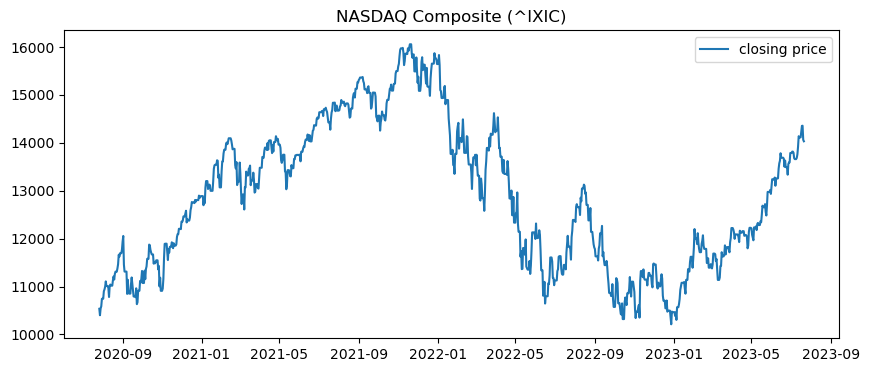

In [56]:
# Plot historical price data
plt.figure(figsize=(10,4))
plt.title(symbol_name)
plt.plot(df['Close'], label='closing price')
plt.legend()
plt.show()

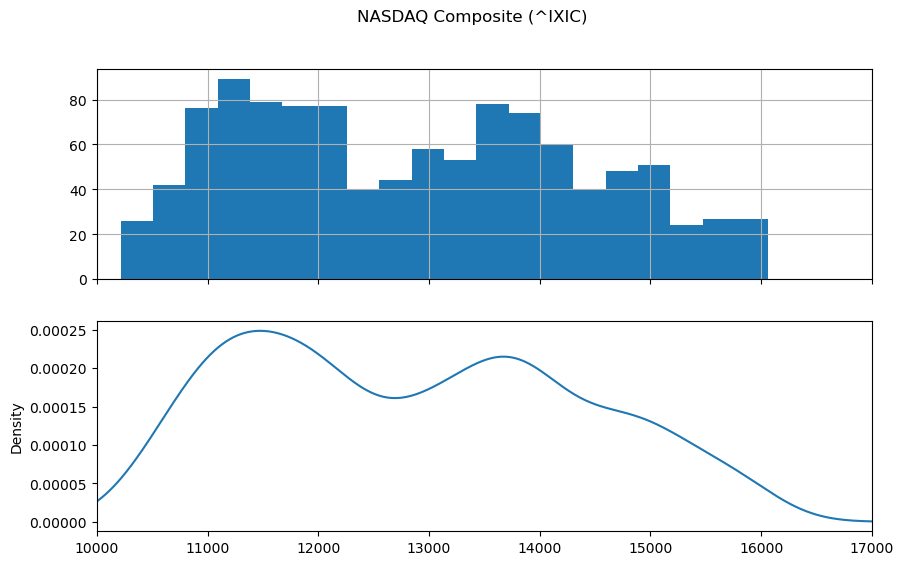

In [57]:
# Histogram/density plots of time series
fig, ax = plt.subplots(2, figsize=(10,6), sharex=True)
fig.suptitle(symbol_name)
df['Close'].hist(ax=ax[0], bins=20)
df['Close'].plot(kind='kde', ax=ax[1])
ax[0].set_xlim([10000,17000])
plt.show()

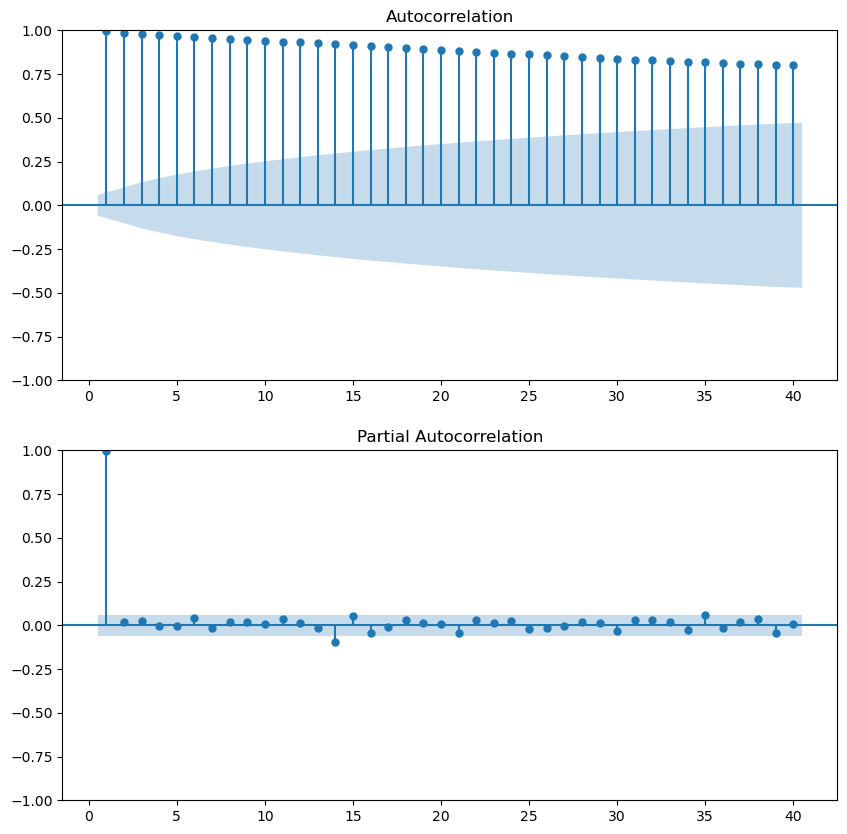

In [58]:

# ACF and PACF plots of time series
def plot_acf_pacf(df):
    # Create figure
    fig, ax = plt.subplots(2, figsize=(10,10))
    # Make ACF plot
    plot_acf(df, lags=40, zero=False, ax=ax[0])
    # Make PACF plot
    plot_pacf(df, lags=40, zero=False, ax=ax[1])
    # Show plots
    return plt.show()

plot_acf_pacf(df['Close'])

ADF Statistic: -34.349906
p-value: 0.000000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


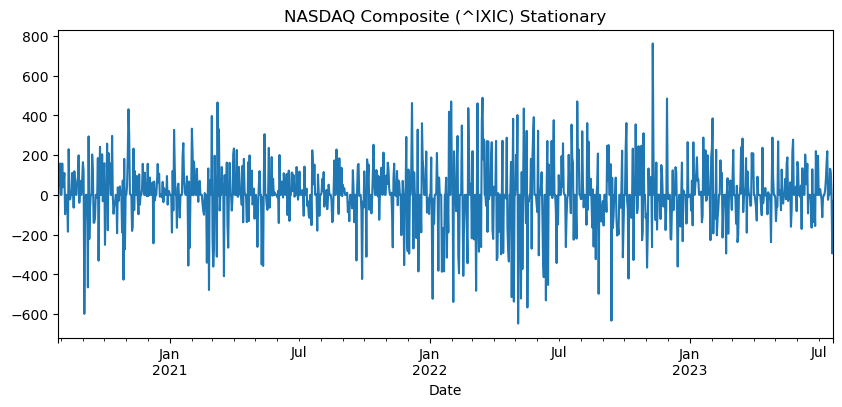

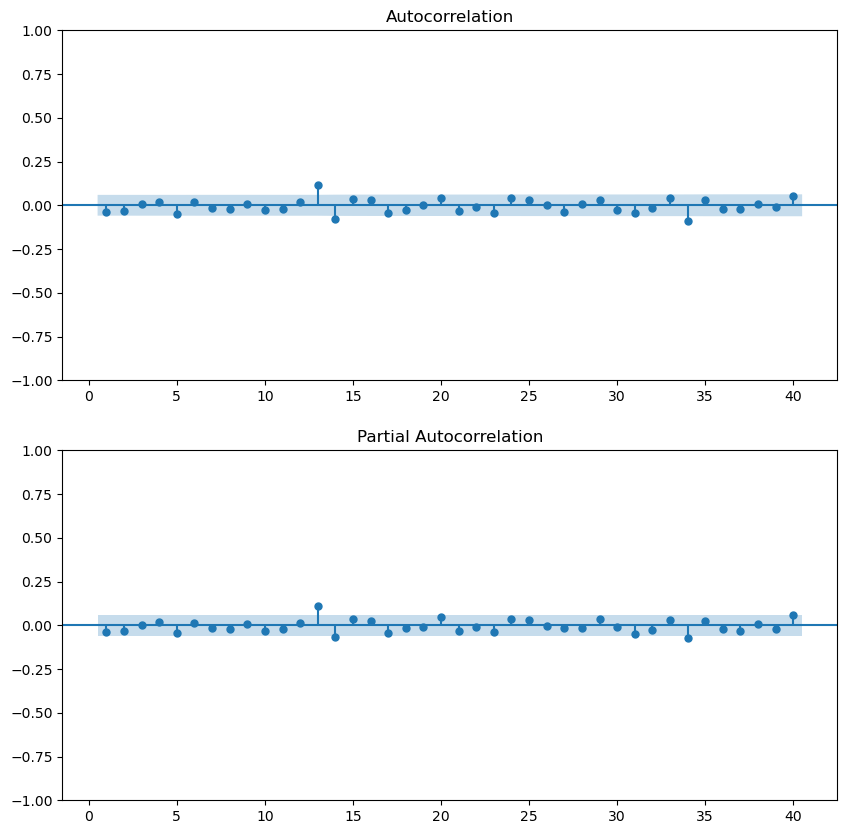

ADF Statistic: -34.349906
p-value: 0.000000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


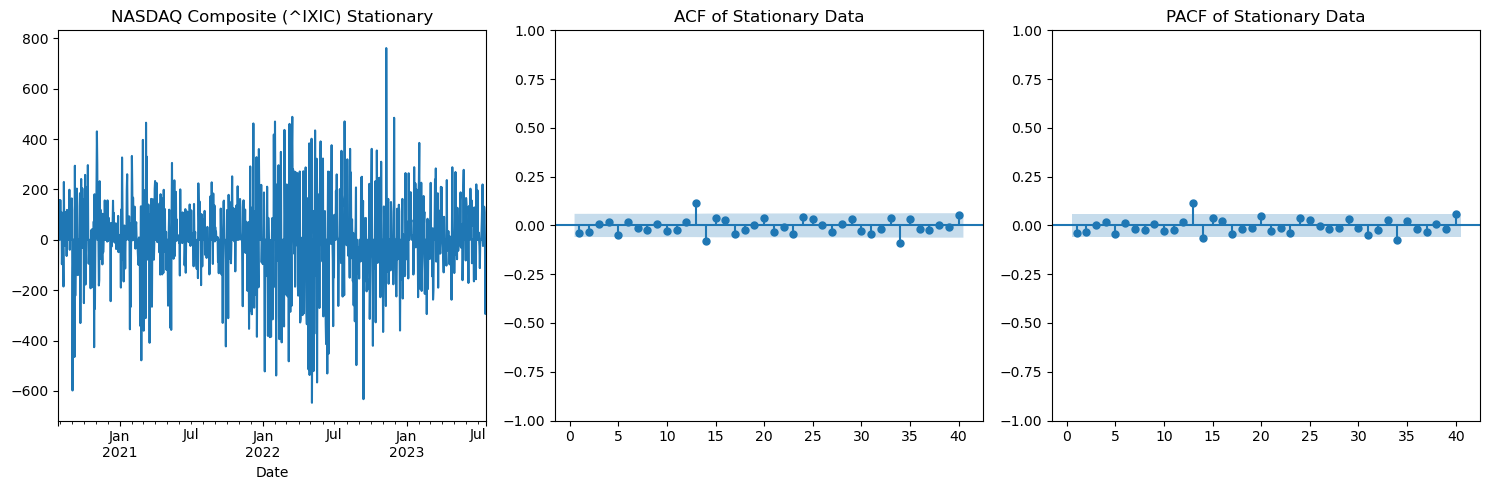

In [59]:
# Transform data from non-stationary to stationary
X = df.Close
# Method 1: difference data
stationary = X.diff(1)
# # Method 2: take the log
# stationary = np.log(X)
# # Method 3: take the square root 
# stationary = np.sqrt(X)
# # Method 4: take the proprtional change
# stationary = X.pct_change(1)
stationary.dropna(axis=0, inplace=True)

# The augmented Dicky-Fuller test - check if stationary
result = adfuller(stationary)
# test statistic - more negative means more likely to be stationary
print('ADF Statistic: %f' % result[0])
# p-value - reject null hypothesis: non-stationary
print('p-value: %f' % result[1])
# critical test statistics - p-values: test statistic for null hypothesis
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# plot stationary dataset
stationary.plot(figsize=(10,4))
plt.title(symbol_name+' Stationary')
plt.show()

# plot ACF & PACF of stationary dataset
plot_acf_pacf(stationary)







fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# The augmented Dicky-Fuller test - check if stationary
result = adfuller(stationary)
# test statistic - more negative means more likely to be stationary
print('ADF Statistic: %f' % result[0])
# p-value - reject null hypothesis: non-stationary
print('p-value: %f' % result[1])
# critical test statistics - p-values: test statistic for null hypothesis
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# Plot stationary dataset
stationary.plot(ax=axes[0], title=symbol_name + ' Stationary')

# Plot ACF of stationary dataset
plot_acf(stationary, lags=40, zero=False, ax=axes[1])
axes[1].set_title('ACF of Stationary Data')

# Plot PACF of stationary dataset
plot_pacf(stationary, lags=40, zero=False, ax=axes[2])
axes[2].set_title('PACF of Stationary Data')

plt.tight_layout()
plt.show()


In [101]:

class Auto_Arima():
    def __init__(self, df, start_p=1, start_q=1, max_p=10, max_q=10,\
        seasonal=False, information_criterion='aic'):
        self.df = df
        self.start_p = start_p
        self.start_q = start_q
        self.max_p = max_p
        self.max_q = max_q
        self.seasonal = seasonal
        self.information_criterion = information_criterion

    def arima_results(self):
        results = pm.auto_arima(
            self.df,
            start_p = self.start_p,
            start_q = self.start_q,
            max_p = self.max_p,
            max_q = self.max_q,
            seasonal = self.seasonal,
            
            # for SARIMA
            m = 14,
            D = 1,
            start_P = 1,
            start_Q = 1,
            max_P = 10,
            max_Q = 10,
            information_criterion = self.information_criterion,
            trace = False,
            error_action = 'ignore',
            suppress_warnings=True,
            stepwise = True,
            scoring = 'mse'
        )
        return results

Train: 763, Test: 327


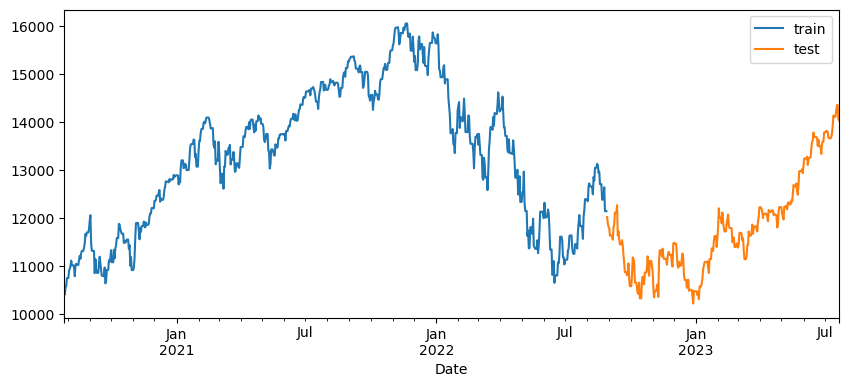

In [102]:
# Train test split
def train_test_split(X, size=0.7):
    train = X[:int(X.shape[0]*size)]
    test = X[int(X.shape[0]*size):]
    return train, test

train, test = train_test_split(X=df['Close'], size=0.7)
print(f'Train: {len(train)}, Test: {len(test)}')

# Plot train & test datasets
fig, ax = plt.subplots(figsize=(10,4))
train.plot(ax=ax, label='train')
test.plot(ax=ax, label='test')
ax.legend()
plt.show()

In [103]:
# Fit model with auto-arima
arima_model = Auto_Arima(train)
results = arima_model.arima_results()

C:\anaconda\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (14) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


In [104]:
# Check residuals
# Prob(Q) - p-value for null hypothesis that residuals are uncorrelated
# Prob(JB) - p-value for null hypothesis that residuals are normal
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  763
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -4971.551
Date:                Mon, 04 Sep 2023   AIC                           9945.101
Time:                        21:17:04   BIC                           9949.737
Sample:                    07-27-2020   HQIC                          9946.886
                         - 08-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.716e+04    994.085     27.322      0.000    2.52e+04    2.91e+04
Ljung-Box (L1) (Q):                   2.38   Jarque-Bera (JB):               148.09
Prob(Q):                              0.12   Pr

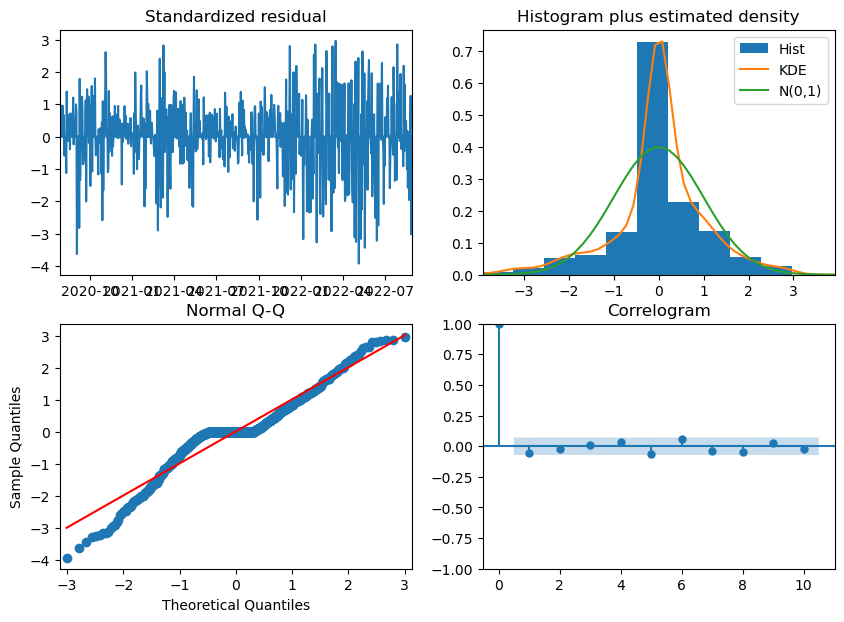

In [105]:
# Residuals are not correlated and are not normally distributed

# Plot diagnostics - check residuals:
# 1.Standardized residual - should be white noise
# 2.Histogram plus estimated density - expected normal distribution
# and kde overlap each other
# 3.Normal Q-Q - all points should lay on red line, except perhaps
# for some values at both ends
# 4.Correlogram - acf plot, 95% should not be significant
plot_diag = results.plot_diagnostics(figsize=(10,7))

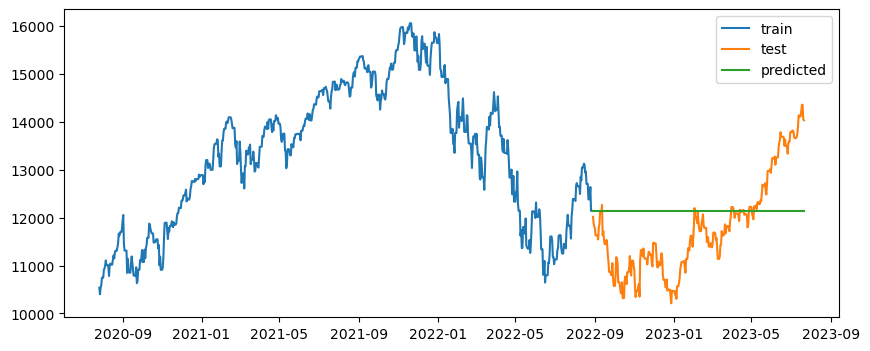

RMSE: 1064.42


In [106]:
# Out-of-sample multi-step-forecast based on auto_arima results
predicted = results.predict(n_periods=len(test))
predicted = pd.DataFrame(predicted, index=test.index, columns=['predicted'])

def plot_train_test(train, test, df):
    # Plot the predictions for validation set
    plt.figure(figsize=(10,4))
    plt.plot(train, label='train')
    plt.plot(test, label='test')
    plt.plot(df, label='predicted')
    plt.legend()
    plt.show()

    # calculate RMSE
    rmse = np.sqrt(mean_squared_error(test, df))
    print(f'RMSE: {rmse:.2f}')

plot_train_test(train, test, predicted)

In [107]:
# ARIMA multi-step-forecast is pretty bad, so let's compare it with one-step-forecast
def one_step_forecast():
    predicted, conf_int = results.predict(n_periods=1, return_conf_int=True)
    return (
        predicted.tolist()[0],
        np.asarray(conf_int).tolist()[0])

predictions = []
confidence_intervals = []

for x in test:
    predicted, conf = one_step_forecast()
    predictions.append(predicted)
    confidence_intervals.append(conf)

    # Updates the existing model
    results.update(x)

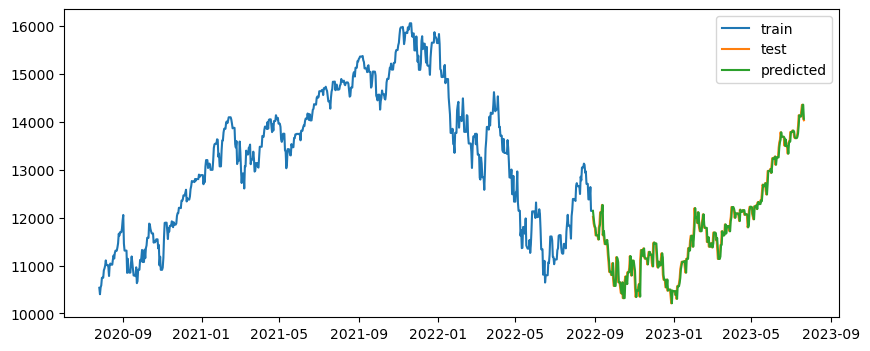

RMSE: 142.12
MAE: 92.10
MSE: 20197.91


In [108]:
# Out-of-sample one-step-forecast based on auto_arima results
predicted = pd.DataFrame(predictions, index=test.index, columns=['predicted'])

# Plot real price vs one-step-forecast
plot_train_test(train, test, predicted)

# calculate RMSE
rmse = np.sqrt(mean_squared_error(test, predictions))
# print(f'RMSE: {rmse:.2f}')
mae = np.mean(np.abs(test - predictions))

# Calculate Mean Squared Error (MSE)
mse = np.mean((test - predictions) ** 2)
print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')

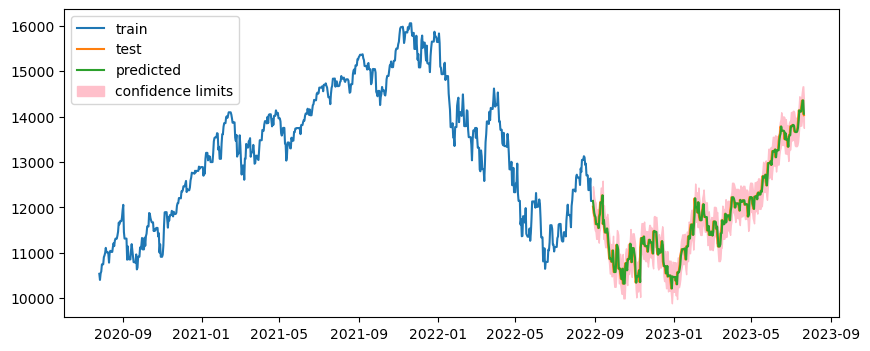

In [109]:
# Forecast with confidence intervals
lower_limits = [row[0] for row in confidence_intervals]
upper_limits = [row[1] for row in confidence_intervals]
# Plot predictions with conf_int
plt.figure(figsize=(10,4))
plt.plot(train, label='train')
plt.plot(test, label='test')
plt.plot(predicted, label='predicted')
plt.fill_between(test.index, lower_limits,
		 upper_limits, color='pink', label='confidence limits')
plt.legend()
plt.show()

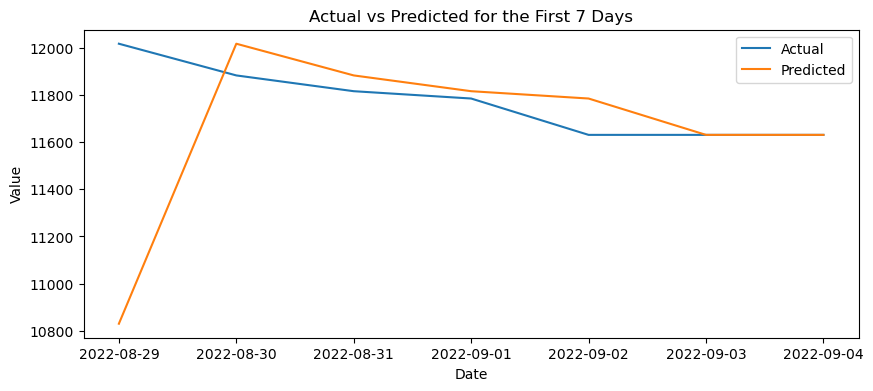

MAE: 225.00
MSE: 208441.64
RMSE: 456.55


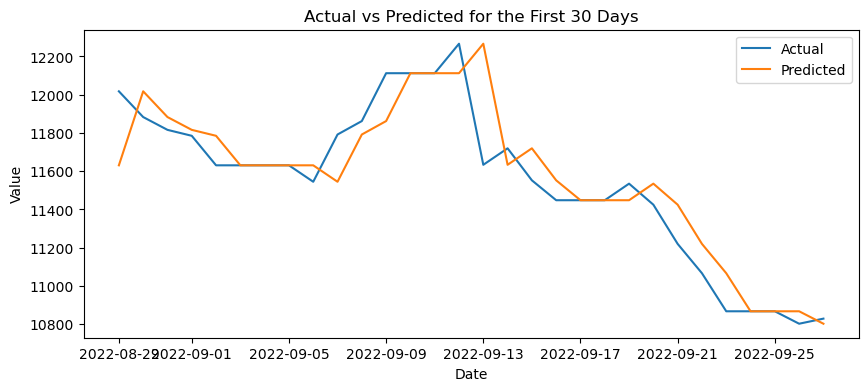

MAE: 113.89
MSE: 31096.86
RMSE: 176.34


In [120]:
# One-step-forecast function
def one_step_forecast():
    predicted, _ = results.predict(n_periods=1, return_conf_int=True)
    return predicted.tolist()[0]

# Perform 7-day forecast for the first 7 days in the test set
test_7_days = test[:7]
predictions = []

for x in test_7_days:
    predicted = one_step_forecast()
    predictions.append(predicted)
    results.update(x)  # Update model with actual value

# Convert predictions to an array
predictions = np.array(predictions)

# Create index for the 7-day forecast
forecast_index = test_7_days.index

# Create a DataFrame for the predicted values
predicted_df = pd.DataFrame(predictions, index=forecast_index, columns=['predicted'])

# Plot real price vs one-step-forecast for the first 7 days
plt.figure(figsize=(10, 4))
plt.plot(test_7_days, label='Actual')
plt.plot(predicted_df, label='Predicted')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Predicted for the First 7 Days')
plt.show()

# Calculate metrics
rmse = np.sqrt(mean_squared_error(test_7_days, predictions))
mae = np.mean(np.abs(test_7_days - predictions))
mse = np.mean((test_7_days - predictions) ** 2)

print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')

# One-step-forecast function
def one_step_forecast():
    predicted, _ = results.predict(n_periods=1, return_conf_int=True)
    return predicted.tolist()[0]

# Perform 30-day forecast for the first 30 days in the test set
num_forecast_days = 30
test_30_days = test[:num_forecast_days]
predictions = []

for x in test_30_days:
    predicted = one_step_forecast()
    predictions.append(predicted)
    results.update(x)  # Update model with actual value

# Convert predictions to an array
predictions = np.array(predictions)

# Create index for the 30-day forecast
forecast_index = test_30_days.index

# Create a DataFrame for the predicted values
predicted_df = pd.DataFrame(predictions, index=forecast_index, columns=['predicted'])

# Plot real price vs one-step-forecast for the first 30 days
plt.figure(figsize=(10, 4))
plt.plot(test_30_days, label='Actual')
plt.plot(predicted_df, label='Predicted')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Predicted for the First 30 Days')
plt.show()

# Calculate metrics
rmse = np.sqrt(mean_squared_error(test_30_days, predictions))
mae = np.mean(np.abs(test_30_days - predictions))
mse = np.mean((test_30_days - predictions) ** 2)

print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')


In [131]:
# Let's make predictions other way
# SARIMAX 
# one-step-ahead in-sample predictions with uncertainty
def sarimax_model(df, trend='ct', steps=100, dynamic=False):
    model = SARIMAX(df, order=(7,1,7), trend=trend)
    results = model.fit()
    one_step_forecast = results.get_prediction(start=-steps, dynamic=dynamic)
    # Get in-sample predicted mean values
    predictions = one_step_forecast.predicted_mean
    # Get confidence intervals of in-sample forecasts
    confidence_intervals = one_step_forecast.conf_int()
    lower_limits = confidence_intervals['lower Close']
    upper_limits = confidence_intervals['upper Close']
    return predictions, lower_limits, upper_limits

In [132]:
%%capture
# Run model
predictions, lower_limits, upper_limits =\
    sarimax_model(df=test, trend='ct', steps=100, dynamic=False)

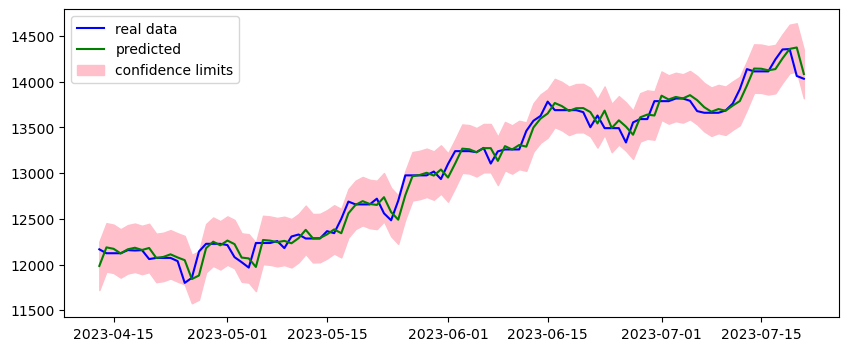

In [133]:
# Plot real data
def plot_sarimax_pred(df, steps=100):
    plt.figure(figsize=(10,4))
    plt.plot(df.index[-steps:], df[-steps:], 
            color='b', label='real data')
    # Plot predictions 
    plt.plot(predictions.index, predictions, 
            color='g', label='predicted')
    # Plot confidence limits
    plt.fill_between(lower_limits.index, lower_limits,
            upper_limits, color='pink', label='confidence limits')
    plt.legend()
    plt.show()

plot_sarimax_pred(df=test, steps=100)

In [137]:
%%capture
# Dynamic forecast for next 30 days
# Run model
predictions, lower_limits, upper_limits =\
    sarimax_model(df=df['Close'], trend='ct', steps=30, dynamic=True)

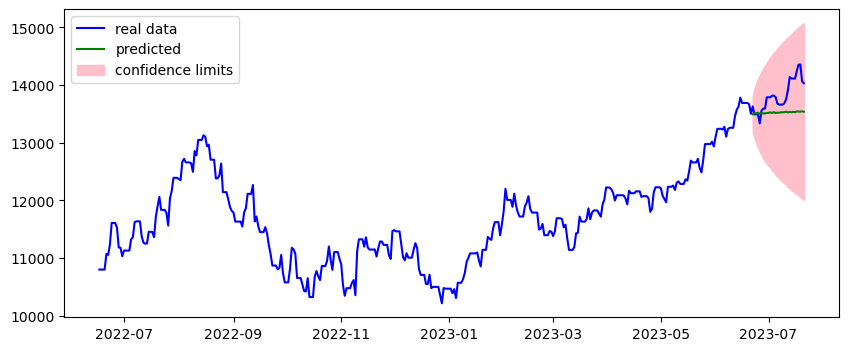

In [138]:
# Plot dynamic forecast
plot_sarimax_pred(df=df['Close'], steps=400)

In [139]:
%%capture
# One-step-forecast for next 30 days
# Run model
predictions, lower_limits, upper_limits =\
    sarimax_model(df=df['Close'], trend='ct', steps=30, dynamic=False)

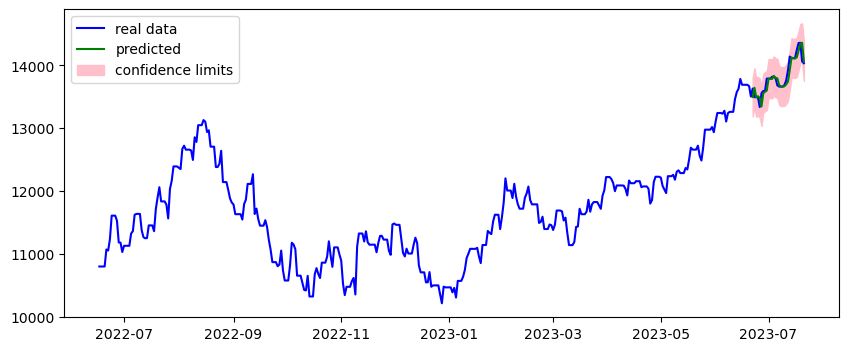

In [140]:
# Plot one-step-forecast for comparison with multi-step-forecast
plot_sarimax_pred(df=df['Close'], steps=400)

In [141]:
# Compare predictions with real data
forecast_vs_real = pd.concat([round(df['Close'][-50:],2), round(predictions,2)], axis=1)
forecast_vs_real.columns = ['Real Price', 'Forecast']
forecast_vs_real['Error_%'] = round(abs(forecast_vs_real['Forecast'] - forecast_vs_real['Real Price'])/\
                        forecast_vs_real['Real Price'] * 100, 3)
print(forecast_vs_real.head(5))
print()
print(f"Mean error: {round(forecast_vs_real['Error_%'].mean(),3)} %")

            Real Price  Forecast  Error_%
2023-06-02    13240.77       NaN      NaN
2023-06-03    13240.77       NaN      NaN
2023-06-04    13240.77       NaN      NaN
2023-06-05    13229.43       NaN      NaN
2023-06-06    13276.42       NaN      NaN

Mean error: 0.522 %


In [142]:
# Calculate Mean Absolute Error (MAE)
forecast_vs_real['MAE'] = abs(forecast_vs_real['Forecast'] - forecast_vs_real['Real Price'])
mae = forecast_vs_real['MAE'].mean()

# Calculate Mean Squared Error (MSE)
forecast_vs_real['MSE'] = (forecast_vs_real['Forecast'] - forecast_vs_real['Real Price'])**2
mse = forecast_vs_real['MSE'].mean()

rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {round(mae, 3)}")
print(f"Mean Squared Error (MSE): {round(mse, 3)}")
print(f"Root Mean Squared Error (RMSE): {round(rmse, 3)}")

Mean Absolute Error (MAE): 72.186
Mean Squared Error (MSE): 11915.841
Root Mean Squared Error (RMSE): 109.16


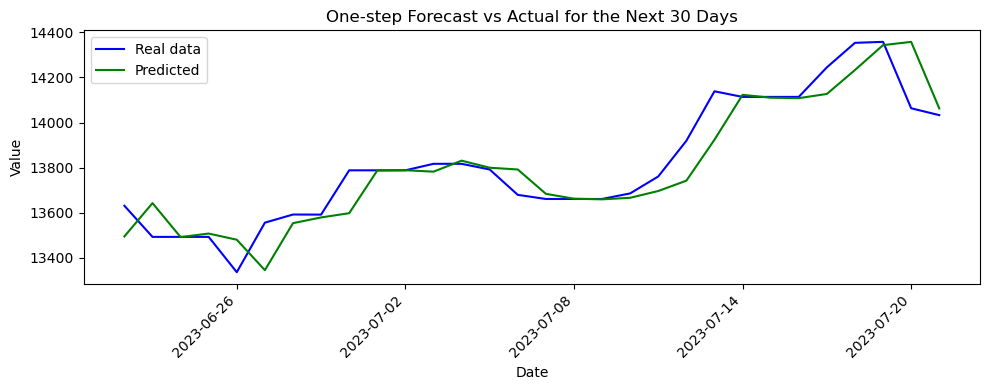

In [146]:
dates = pd.date_range(start='2023-06-21', periods=30, freq='D')
actual_values = np.random.rand(30)
predicted_values = np.random.rand(30)

# Plot real data vs predictions with adjusted x-axis ticks
def plot_one_step_vs_actual(df, predictions, steps=30):
    plt.figure(figsize=(10, 4))
    plt.plot(df.index[-steps:], df['Close'][-steps:], color='b', label='Real data')
    plt.plot(predictions.index, predictions, color='g', label='Predicted')
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title('One-step Forecast vs Actual for the Next 30 Days')
    
    # Adjust x-axis ticks
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(6))  # Set the number of x-axis ticks
    
    plt.tight_layout()
    plt.show()

# Call the plot function
plot_one_step_vs_actual(df=df, predictions=predictions, steps=30)


In [148]:
# Short-term prediction
# SARIMAX 
# one-step-ahead in-sample predictions with uncertainty
def sarimax_model(df, trend='ct', steps=7, dynamic=False):
    model = SARIMAX(df, order=(7,1,7), trend=trend)
    results = model.fit()
    one_step_forecast = results.get_prediction(start=-steps, dynamic=dynamic)
    # Get in-sample predicted mean values
    predictions = one_step_forecast.predicted_mean
    # Get confidence intervals of in-sample forecasts
    confidence_intervals = one_step_forecast.conf_int()
    lower_limits = confidence_intervals['lower Close']
    upper_limits = confidence_intervals['upper Close']
    return predictions, lower_limits, upper_limits

In [149]:
%%capture
# Run model
predictions, lower_limits, upper_limits =\
    sarimax_model(df=test, trend='ct', steps=7, dynamic=False)

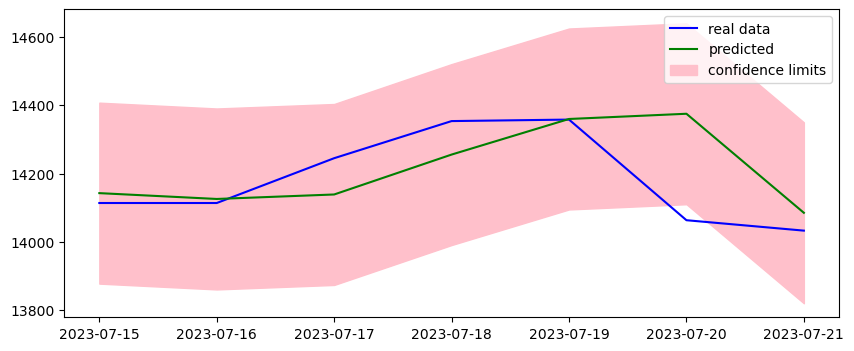

In [150]:
# Plot real data
def plot_sarimax_pred(df, steps=7):
    plt.figure(figsize=(10,4))
    plt.plot(df.index[-steps:], df[-steps:], 
            color='b', label='real data')
    # Plot predictions 
    plt.plot(predictions.index, predictions, 
            color='g', label='predicted')
    # Plot confidence limits
    plt.fill_between(lower_limits.index, lower_limits,
            upper_limits, color='pink', label='confidence limits')
    plt.legend()
    plt.show()

plot_sarimax_pred(df=test, steps=7)

In [151]:
%%capture
# Dynamic forecast for next 7 days
# Run model
predictions, lower_limits, upper_limits =\
    sarimax_model(df=df['Close'], trend='ct', steps=7, dynamic=True)

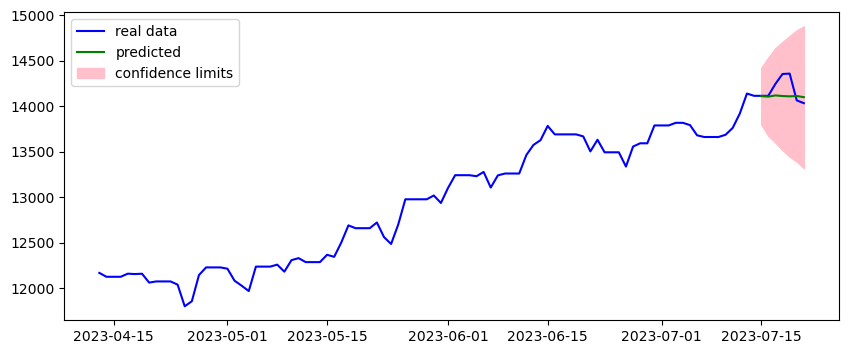

In [152]:
# Plot dynamic forecast
plot_sarimax_pred(df=df['Close'], steps=100)

In [153]:
# Compare predictions with real data
forecast_vs_real = pd.concat([round(df['Close'][-7:],2), round(predictions,2)], axis=1)
forecast_vs_real.columns = ['Real Price', 'Forecast']
forecast_vs_real['Error_%'] = round(abs(forecast_vs_real['Forecast'] - forecast_vs_real['Real Price'])/\
                        forecast_vs_real['Real Price'] * 100, 3)
print(forecast_vs_real.head(5))
print()
print(f"Mean error: {round(forecast_vs_real['Error_%'].mean(),3)} %")

            Real Price  Forecast  Error_%
2023-07-15    14113.70  14110.07    0.026
2023-07-16    14113.70  14104.77    0.063
2023-07-17    14244.95  14118.16    0.890
2023-07-18    14353.64  14111.35    1.688
2023-07-19    14358.02  14107.96    1.742

Mean error: 0.746 %


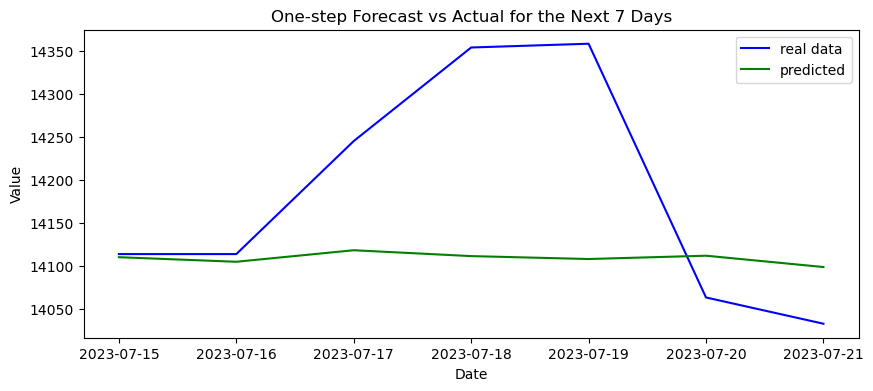

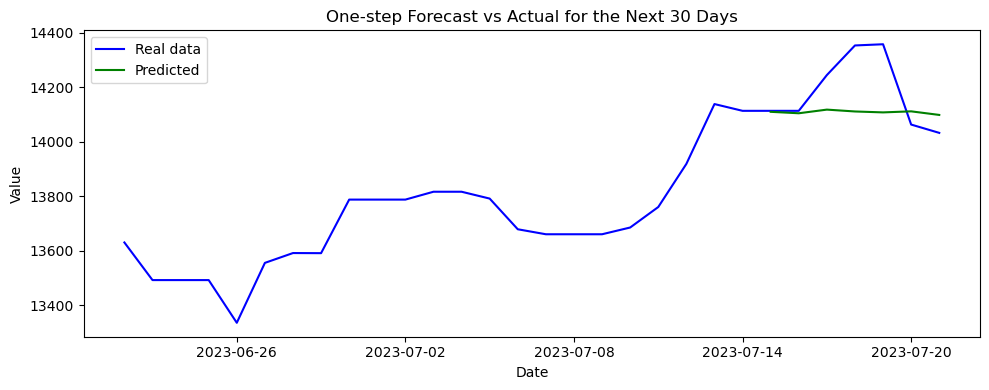

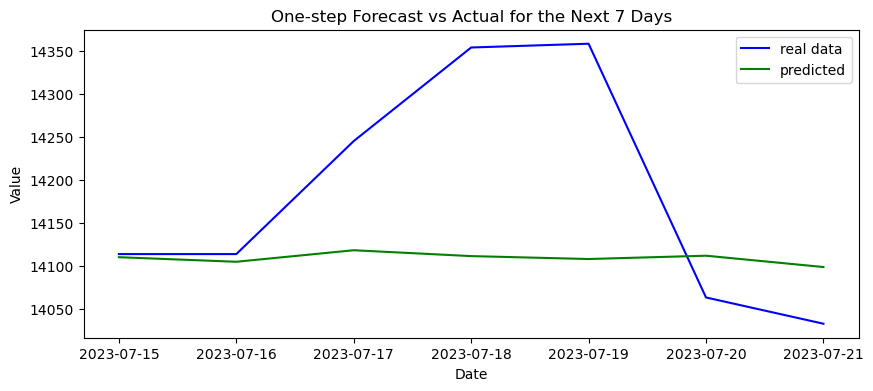

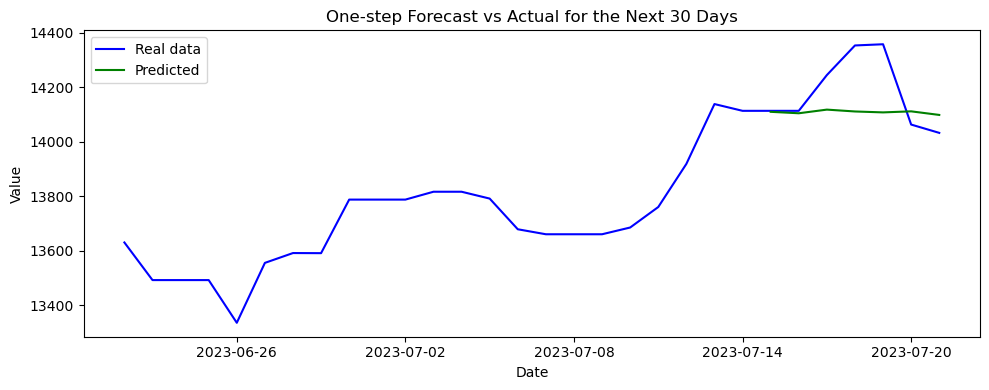

In [164]:

# Plot real data vs predictions
def plot_sarimax_pred(df, predictions, steps=7):
    plt.figure(figsize=(10,4))
    plt.plot(df.index[-steps:], df[-steps:], 
            color='b', label='real data')
    plt.plot(predictions.index, predictions, 
            color='g', label='predicted')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title('One-step Forecast vs Actual for the Next 7 Days')
    plt.legend()
    plt.show()
    

# Call the plot function
plot_sarimax_pred(df=test, predictions=predictions, steps=7)
dates = pd.date_range(start='2023-06-21', periods=30, freq='D')
actual_values = np.random.rand(30)
predicted_values = np.random.rand(30)

# Plot real data vs predictions with adjusted x-axis ticks
def plot_one_step_vs_actual(df, predictions, steps=30):
    plt.figure(figsize=(10, 4))
    plt.plot(df.index[-steps:], df['Close'][-steps:], color='b', label='Real data')
    plt.plot(predictions.index, predictions, color='g', label='Predicted')
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title('One-step Forecast vs Actual for the Next 30 Days')
    
    # Adjust x-axis ticks
#     plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(6))  # Set the number of x-axis ticks
    
    plt.tight_layout()
    plt.show()

# Call the plot function
plot_one_step_vs_actual(df=df, predictions=predictions, steps=30)









# Plot real data vs predictions
def plot_sarimax_pred(df, predictions, steps=7):
    plt.figure(figsize=(10,4))
    plt.plot(df.index[-steps:], df[-steps:], 
            color='b', label='real data')
    plt.plot(predictions.index, predictions, 
            color='g', label='predicted')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title('One-step Forecast vs Actual for the Next 7 Days')
    plt.legend()
    plt.show()
    

# Call the plot function
plot_sarimax_pred(df=test, predictions=predictions, steps=7)
dates = pd.date_range(start='2023-06-21', periods=30, freq='D')
actual_values = np.random.rand(30)
predicted_values = np.random.rand(30)

# Plot real data vs predictions with adjusted x-axis ticks
def plot_one_step_vs_actual(df, predictions, steps=30):
    plt.figure(figsize=(10, 4))
    plt.plot(df.index[-steps:], df['Close'][-steps:], color='b', label='Real data')
    plt.plot(predictions.index, predictions, color='g', label='Predicted')
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title('One-step Forecast vs Actual for the Next 30 Days')
    
    # Adjust x-axis ticks
#     plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(6))  # Set the number of x-axis ticks
    
    plt.tight_layout()
    plt.show()

# Call the plot function
plot_one_step_vs_actual(df=df, predictions=predictions, steps=30)


In [97]:
# Calculate Mean Absolute Error (MAE)
forecast_vs_real['MAE'] = abs(forecast_vs_real['Forecast'] - forecast_vs_real['Real Price'])
mae = forecast_vs_real['MAE'].mean()

# Calculate Mean Squared Error (MSE)
forecast_vs_real['MSE'] = (forecast_vs_real['Forecast'] - forecast_vs_real['Real Price'])**2
mse = forecast_vs_real['MSE'].mean()

rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {round(mae, 3)}")
print(f"Mean Squared Error (MSE): {round(mse, 3)}")
print(f"Root Mean Squared Error (RMSE): {round(rmse, 3)}")

Mean Absolute Error (MAE): 106.579
Mean Squared Error (MSE): 20584.507
Root Mean Squared Error (RMSE): 143.473


In [98]:
%%capture
# One-step-forecast for next 7 days
# Run model
predictions, lower_limits, upper_limits =\
    sarimax_model(df=df['Close'], trend='ct', steps=50, dynamic=False)

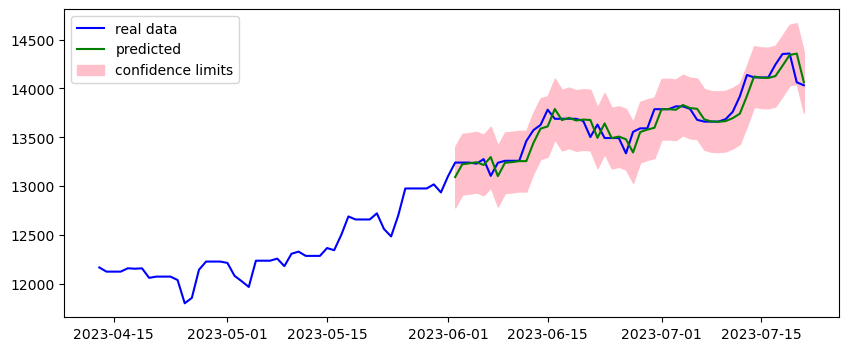

In [99]:
# Plot dynamic forecast
plot_sarimax_pred(df=df['Close'], steps=100)

In [100]:
# Compare predictions with real data
forecast_vs_real = pd.concat([round(df['Close'][-7:],2), round(predictions,2)], axis=1)
forecast_vs_real.columns = ['Real Price', 'Forecast']
forecast_vs_real['Error_%'] = round(abs(forecast_vs_real['Forecast'] - forecast_vs_real['Real Price'])/\
                        forecast_vs_real['Real Price'] * 100, 3)
print(forecast_vs_real.head(5))
print()
print(f"Mean error: {round(forecast_vs_real['Error_%'].mean(),3)} %")

            Real Price  Forecast  Error_%
2023-06-02         NaN  13092.56      NaN
2023-06-03         NaN  13223.66      NaN
2023-06-04         NaN  13233.33      NaN
2023-06-05         NaN  13244.57      NaN
2023-06-06         NaN  13216.39      NaN

Mean error: 0.592 %


In [35]:
# Calculate Mean Absolute Error (MAE)
forecast_vs_real['MAE'] = abs(forecast_vs_real['Forecast'] - forecast_vs_real['Real Price'])
mae = forecast_vs_real['MAE'].mean()

# Calculate Mean Squared Error (MSE)
forecast_vs_real['MSE'] = (forecast_vs_real['Forecast'] - forecast_vs_real['Real Price'])**2
mse = forecast_vs_real['MSE'].mean()

rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {round(mae, 3)}")
print(f"Mean Squared Error (MSE): {round(mse, 3)}")
print(f"Root Mean Squared Error (RMSE): {round(rmse, 3)}")

Mean Absolute Error (MAE): 83.826
Mean Squared Error (MSE): 16633.359
Root Mean Squared Error (RMSE): 128.97
